In [8]:
import kagglehub as kh
import gym 
import gym_anytrading
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from stable_baselines3 import PPO
from gym_anytrading.envs import StocksEnv
from gym import spaces
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# Download dataset
path = kh.dataset_download("sudalairajkumar/cryptocurrencypricehistory")
print("Path to dataset files:", path)

# Load data
df = pd.read_csv(os.path.join(path, 'coin_Bitcoin.csv'))
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Open', 'High', 'Low', 'Close']]

# Filter data to include range from 2015 to 2020
df = df[(df['Date'] >= '2015-01-01') & (df['Date'] <= '2020-12-31')]

# Normalize data and remove outliers
df_numeric = df[['Open', 'High', 'Low', 'Close']].astype(float)
df_numeric.dropna(inplace=True)
z_scores = np.abs(stats.zscore(df_numeric))
df_numeric = df_numeric[(z_scores < 3).all(axis=1)]
df = df.loc[df_numeric.index].copy()

scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close']])
print(df.head())

Path to dataset files: /home/gabbycamm/.cache/kagglehub/datasets/sudalairajkumar/cryptocurrencypricehistory/versions/3
                   Date      Open      High       Low     Close
612 2015-01-01 23:59:59  0.007449  0.005573  0.007596  0.007047
613 2015-01-02 23:59:59  0.007119  0.005338  0.007572  0.007088
614 2015-01-03 23:59:59  0.007159  0.005302  0.005841  0.005330
615 2015-01-04 23:59:59  0.005410  0.003871  0.004590  0.004456
616 2015-01-05 23:59:59  0.004576  0.003415  0.004988  0.004988


In [10]:
# Split dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42, shuffle=True)
X_train = train_df[['Open', 'High', 'Low']]
y_train = train_df['Close']
X_test = test_df[['Open', 'High', 'Low']]
y_test = test_df['Close']

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)


In [11]:
# Calculate model accuracy and RMSE
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Model Accuracy (R^2 Score): {r2}")
print(f"Model RMSE: {rmse}")

# Prepare the results dataframe
test_df = test_df.copy()
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
}, index=test_df.index)

Model Accuracy (R^2 Score): 0.9985628438453269
Model RMSE: 0.009003953573532644


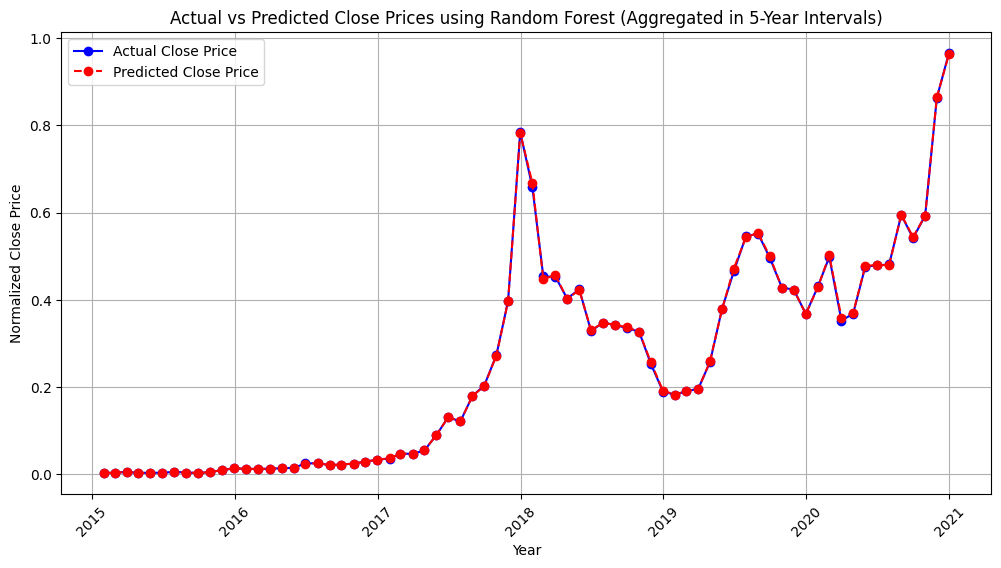

NameError: name 'joblib' is not defined

In [12]:
# Aggregate results monthly and plot
monthly_results = results_df.resample('M').mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Close Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Close Price', color='red', linestyle='dashed', marker='o')
plt.title('Actual vs Predicted Close Prices using Random Forest (Aggregated in 5-Year Intervals)')
plt.xlabel('Year')
plt.ylabel('Normalized Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Save the trained model to a file
joblib.dump(rf_model, 'random_forest_model.pkl')